In [1]:
import os
import sys
import csv
import json
from tqdm import tqdm
import numpy as np
import random
import pprint
import shutil
from datetime import datetime, timedelta
from ast import literal_eval

import cv2
import pprint
from IPython.display import Video

# MOMA-LRG

Initialize the MOMA API.

In [2]:
import sys
sys.path.insert(0, "/local1/telinwu/research/resources/moma/")
from momaapi import MOMA

dir_moma = "/local1/telinwu/research/resources/MOMA-LRG"  # replace with your dataset directory
moma = MOMA(dir_moma)

### Video Activity Classification

A unique ID is assigned to each activity instance. The first step is to obtain all the activity IDs associated with a specific split.

In [3]:
ids_act = moma.get_ids_act(split="train")
print(f"ids_act: len={len(ids_act)}, head={ids_act[:3]}")

ids_act: len=904, head=['-49z-lj8eYQ', '-50j97YPM6I', '-8ulhNOuce8']


Using activity IDs, we can locate associated video files.

In [4]:
paths_act = moma.get_paths(ids_act=ids_act)
print(f"paths_act: len={len(paths_act)}, head={paths_act[:3]}")

paths_act: len=904, head=['/local1/telinwu/research/resources/MOMA-LRG/videos/activity/-49z-lj8eYQ.mp4', '/local1/telinwu/research/resources/MOMA-LRG/videos/activity/-50j97YPM6I.mp4', '/local1/telinwu/research/resources/MOMA-LRG/videos/activity/-8ulhNOuce8.mp4']


Using activity IDs, we can also retrieve their full annotations, including their class IDs.

In [5]:
anns_act = moma.get_anns_act(ids_act)
cids_act = [ann_act.cid for ann_act in anns_act]
cnames_act = [moma.taxonomy['act'][cid_act] for cid_act in cids_act]
print(f"cids_act: len={len(cids_act)}, head={cids_act[:3]}")
print(f"cnames_act: head={cnames_act[:3]}")

cids_act: len=904, head=[2, 16, 19]
cnames_act: head=['basketball game', 'reception service', 'table tennis game']


### Video Sub-activity Classification

The process of constructing a data module for video sub-activity classification is very similar to that of constructing a data module for video activity classification.

In [6]:
ids_sact = moma.get_ids_sact(split="train")
paths_sact = moma.get_paths(ids_sact=ids_sact)
anns_sact = moma.get_anns_sact(ids_sact)
cids_sact = [ann_sact.cid for ann_sact in anns_sact]
cnames_sact = [moma.taxonomy['sact'][cid_sact] for cid_sact in cids_sact]
print(f"ids_sact: head={ids_sact[:3]}")
print(f"paths_sact: head={paths_sact[:3]}")
print(f"cids_sact: head={cids_sact[:3]}")
print(f"cnames_sact: head={cnames_sact[:3]}")

ids_sact: head=['00010', '00011', '00012']
paths_sact: head=['/local1/telinwu/research/resources/MOMA-LRG/videos/sub_activity/00010.mp4', '/local1/telinwu/research/resources/MOMA-LRG/videos/sub_activity/00011.mp4', '/local1/telinwu/research/resources/MOMA-LRG/videos/sub_activity/00012.mp4']
cids_sact: head=[5, 5, 7]
cnames_sact: head=['the adult is explaining to the child how to ride a bike', 'the adult is explaining to the child how to ride a bike', 'the adult is holding the child on the bike']


We can trace back the activity label of each sub-activity instance.

In [331]:
ids_act = moma.get_ids_act(ids_sact=ids_sact)
anns_act = moma.get_anns_act(ids_act)
cids_act = [ann_act.cid for ann_act in anns_act]
cnames_act = [moma.taxonomy['act'][cid_act] for cid_act in cids_act]
print(f"cids_act: head={cids_act[:3]}")
print(f"cnames_act: head={cnames_act[:3]}")

cids_act: head=[2, 16, 19]
cnames_act: head=['basketball game', 'reception service', 'table tennis game']


* <span style="color:magenta">**MOMA-LRG is most likely not suitable for action-learning.**</span>

# HowTo100M

In [8]:
ls /local1/telinwu/research/resources/HowTo100M/

all_videos/  annotations/  download_instructions/  HowTo100M.zip  to_show.mp4


In [9]:
howto100m_data_root = "/local1/telinwu/research/resources/HowTo100M"
howto100m_annots_root = os.path.join(howto100m_data_root, "annotations")
howto100m_downloads_root = os.path.join(howto100m_data_root, "download_instructions")
howto100m_videos_root = os.path.join(howto100m_data_root, "all_videos")

In [10]:
howto100m_v1_csv_f = os.path.join(howto100m_annots_root, "HowTo100M_v1.csv")

In [11]:
howto100m_v1_info = csv.DictReader(open(howto100m_v1_csv_f))

howto100m_top_categories = {}
howto100m_sec_categories = {}
video_id_to_categories = {}

for row in howto100m_v1_info:
    video_id = row["video_id"]
    category_1 = row["category_1"]
    category_2 = row["category_2"]
    if category_1 not in howto100m_top_categories:
        howto100m_top_categories[category_1] = []
    if category_2 not in howto100m_sec_categories:
        howto100m_sec_categories[category_2] = []
    howto100m_top_categories[category_1].append(video_id)
    howto100m_sec_categories[category_2].append(video_id)
    video_id_to_categories[video_id] = {
        "top_category": category_1,
        "sec_category": category_2,
    }

for cat in sorted(howto100m_top_categories):
    if len(cat) == 0:
        cat_name = "Root"
    else:
        cat_name = cat
    print("{}  Cnt: {}".format(cat_name, len(howto100m_top_categories[cat])))
    
print("{} top categories, {} secondary categories.".format(
    len(howto100m_top_categories), len(howto100m_sec_categories)))

Root  Cnt: 4289
Arts and Entertainment  Cnt: 9763
Cars & Other Vehicles  Cnt: 68809
Computers and Electronics  Cnt: 5286
Education and Communications  Cnt: 15350
Family Life  Cnt: 1041
Finance and Business  Cnt: 792
Food and Entertaining  Cnt: 498475
Health  Cnt: 15664
Hobbies and Crafts  Cnt: 255865
Holidays and Traditions  Cnt: 27837
Home and Garden  Cnt: 270135
Personal Care and Style  Cnt: 16075
Pets and Animals  Cnt: 31129
Philosophy and Religion  Cnt: 491
Relationships  Cnt: 39
Sports and Fitness  Cnt: 15976
Travel  Cnt: 194
Work World  Cnt: 590
Youth  Cnt: 1111
20 top categories, 143 secondary categories.


### Make Censored Video Downloading List

In [12]:
howto100m_all_videos_save_dir = "/local1/telinwu/research/resources/HowTo100M/all_videos"

stored_videos = os.listdir(howto100m_all_videos_save_dir)
stored_videos_cnt = len(stored_videos)
stored_video_ids = [x.split(".mp4")[0] for x in stored_videos]

In [13]:
top_categories_to_retain = [
    "Cars & Other Vehicles",
    # "Home and Garden",
]

outfile_name = "_".join([x.split()[0].lower() for x in top_categories_to_retain]) + ".txt"
outfile_path = os.path.join(howto100m_downloads_root, outfile_name)
print(outfile_path)

retained_video_ids = []
for cat in howto100m_top_categories:
    if cat not in top_categories_to_retain:
        continue
    else:
        retained_video_ids += howto100m_top_categories[cat]

print("Retained {} videos.".format(len(retained_video_ids)))

new_retained_video_ids = []
for video_id in retained_video_ids:
    if video_id in stored_video_ids:
        continue
    new_retained_video_ids.append(video_id)
retained_video_ids = new_retained_video_ids

print("To download {} videos.".format(len(retained_video_ids)))

/local1/telinwu/research/resources/HowTo100M/download_instructions/cars.txt
Retained 68809 videos.
To download 5004 videos.


In [15]:
video_url_tmpl = "https://howto100m.inria.fr/dataset/{}.mp4"
videos_to_download_file = outfile_path
videos_to_download = open(videos_to_download_file, "w")

for video_id in retained_video_ids:
    video_url = video_url_tmpl.format(video_id)
    videos_to_download.write(video_url+"\n")
videos_to_download.close()
print("Saving the downloading file at: {}".format(videos_to_download_file))

new_cmd = "wget --user htlog23 --password fb93dc3b1950d18 -i ../download_instructions/{}".format(
    videos_to_download_file.split("/")[-1]
)
print()
print(new_cmd)

Saving the downloading file at: /local1/telinwu/research/resources/HowTo100M/download_instructions/cars.txt

wget --user htlog23 --password fb93dc3b1950d18 -i ../download_instructions/cars.txt


### Captions

In [14]:
howto100m_captions_f = os.path.join(howto100m_annots_root, "caption.json")
assert os.path.exists(howto100m_captions_f)

howto100m_captions = json.load(open(howto100m_captions_f))

In [15]:
print(len(howto100m_captions))

1238911


In [26]:
def howto100m_random_pick_video_captions(
    howto100m_captions,
    video_id=None,
    top_categories=[],
    sec_categories=[],
    howto100m_top_categories=None,
    howto100m_sec_categories=None,
    video_id_to_categories=None,
):
    assert not (len(top_categories) != 0 and len(sec_categories) != 0)

    cat_dict = None
    if len(top_categories) != 0:
        assert howto100m_top_categories is not None
        cats = top_categories
        cat_dict = howto100m_top_categories
    if len(sec_categories) != 0:
        assert howto100m_sec_categories is not None
        cats = sec_categories
        cat_dict = howto100m_sec_categories

    if cat_dict is not None:
        all_video_ids = []
        for cat in cats:
            all_video_ids += cat_dict[cat]
    else:
        all_video_ids = sorted(list(howto100m_captions.keys()))

    rand_video_id = np.random.choice(all_video_ids)

    cats = video_id_to_categories[rand_video_id]
    caps_data = howto100m_captions[rand_video_id]
    starts = caps_data["start"]
    ends = caps_data["end"]
    texts = caps_data["text"]
    caps_list = [(a, b, c) for a, b, c in zip(starts, ends, texts)]
    return rand_video_id, caps_list, cats


video_id, captions_timed, video_cats = howto100m_random_pick_video_captions(
    howto100m_captions=howto100m_captions,
    video_id=None,
    top_categories=[
        "Cars & Other Vehicles",
        "Home and Garden",
    ],
    sec_categories=[
    ],
    howto100m_top_categories=howto100m_top_categories,
    howto100m_sec_categories=howto100m_sec_categories,
    video_id_to_categories=video_id_to_categories,
)

print("Video ID: {}".format(video_id))
print("Top Category: {}".format(video_cats["top_category"]))
print("Sec Category: {}".format(video_cats["sec_category"]))
print("-"*40)
for u, v, x in captions_timed:
    u_min = int(int(u) / 60)
    u_sec = int(u) % 60
    u_subsec = int(str(u - int(u))[2:4])
    v_min = int(int(v) / 60)
    v_sec = int(v) % 60
    v_subsec = int(str(v - int(v))[2:4])
    print("[{:02d}:{:02d}.{:02d}-{:02d}:{:02d}.{:02d}] {}".format(
            u_min, u_sec, u_subsec,
            v_min, v_sec, v_subsec,
            x,
        )
    )
print("-"*40)
####

Video ID: wZEMI1atQq0
Top Category: Home and Garden
Sec Category: Landscaping and Outdoor Building
----------------------------------------
[00:15.10-00:17.46] lawn needs inch
[00:17.46-00:18.96] lawn needs inch water week
[00:18.96-00:20.42] water week entire line getting water evenly
[00:20.42-00:22.71] entire line getting water evenly cup test
[00:22.71-00:24.39] cup test best lawn water
[00:24.39-00:26.96] best lawn water twice week deeply water heavily
[00:26.98-00:28.80] twice week deeply water heavily wait day soil
[00:28.80-00:31.82] wait day soil dry water learn
[00:31.83-00:33.60] dry water learn manage water
[00:33.60-00:35.63] manage water apply water
[00:35.64-00:37.43] apply water area paper cup
[00:37.45-00:40.60] area paper cup demonstration place
[00:40.61-00:42.60] demonstration place paper cups weighted rocks
[00:42.60-00:44.52] paper cups weighted rocks coins random spots yard
[00:44.53-00:46.61] coins random spots yard place sprinkler usual
[00:46.63-00:48.97] plac

In [20]:
video_path =  os.path.join(
    howto100m_videos_root,
    "{}.mp4".format(video_id),
)

if os.path.exists("/local1/telinwu/research/resources/HowTo100M/to_show.mp4"):
    os.remove("/local1/telinwu/research/resources/HowTo100M/to_show.mp4")

cmd = (
    "/home/telinwu/ffmpeg-git-20220910-amd64-static/ffmpeg "
    "-i /local1/telinwu/research/resources/HowTo100M/all_videos/{}.mp4 "
    "-vf \"pad=ceil(iw/2)*2:ceil(ih/2)*2\" -loglevel panic "
    "/local1/telinwu/research/resources/HowTo100M/{}.mp4".format(
        video_id, "to_show"
    )
)
os.system(cmd)

video_path = "/local1/telinwu/research/resources/HowTo100M/to_show.mp4"
print(video_path)

Video(video_path, embed=True)

/local1/telinwu/research/resources/HowTo100M/to_show.mp4


In [99]:
# Some useful ffmpeg commands:
# Lossless output transformation:
# ffmpeg -i all_videos/0JJUB2OicSU.mp4 -c:v libx264 -qp 0 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" output.mp4

### WikiHow Precondition Data

In [12]:
wikihow_preconds_data_root = "/home/telinwu/research/task_2021/preconds/object_tracing/traced_data"
preconds_file_name = "fixed_wikihow-golden_new447-test.jsonl"
preconds_file = os.path.join(wikihow_preconds_data_root, preconds_file_name)
assert os.path.exists(preconds_file)

categories_file = os.path.join(wikihow_preconds_data_root, "wikihow-categories-output.json")

wikihow_url_cats_mapping = {}
for line in open(categories_file):
    cat_info = json.loads(line.strip())
    url = cat_info["url"]
    all_cats = cat_info["categories"]
    top_cat, sec_cat = "Root", "Root"
    if len(all_cats) > 1:
        top_cat = all_cats[1]["category title"]
    if len(all_cats) > 2:
        sec_cat = all_cats[2]["category title"]
    wikihow_url_cats_mapping[url] = {
        "top_category": top_cat,
        "sec_category": sec_cat,
    }

preconds_data = {}
for line in open(preconds_file):
    preconds_datum = json.loads(line.strip())
    url = preconds_datum["url"]
    if url not in preconds_data:
        preconds_data[url] = []
    preconds_data[url].append(preconds_datum)
    
print(len(preconds_data))

237


In [13]:
preconds_top_cats_cnt = {}
for wikihow_url in preconds_data:
    if wikihow_url in wikihow_url_cats_mapping:
        top_cat = wikihow_url_cats_mapping[wikihow_url]["top_category"]
    else:
        top_cat = "Root"
    if top_cat not in preconds_top_cats_cnt:
        preconds_top_cats_cnt[top_cat] = 0    
    preconds_top_cats_cnt[top_cat] += len(preconds_data[wikihow_url])

for cat in sorted(preconds_top_cats_cnt):
    print("{}  Cnt: {}".format(cat, preconds_top_cats_cnt[cat]))

Arts and Entertainment  Cnt: 21
Cars & Other Vehicles  Cnt: 18
Computers and Electronics  Cnt: 31
Education and Communications  Cnt: 16
Finance and Business  Cnt: 2
Food and Entertaining  Cnt: 91
Health  Cnt: 7
Hobbies and Crafts  Cnt: 50
Holidays and Traditions  Cnt: 4
Home and Garden  Cnt: 137
Personal Care and Style  Cnt: 36
Pets and Animals  Cnt: 15
Philosophy and Religion  Cnt: 1
Root  Cnt: 7
Sports and Fitness  Cnt: 9
Travel  Cnt: 2


In [19]:
sys.path.insert(0, "../data_processing")
from preconds_utils import *
from sequencing_utils import show_one_sampled_data as show_one_sampled_data_wikihow
from sequencing_data_processors import WikiHowGeneralProcessor

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

golden_data = make_dict_wrt_id(read_jsonl_file(preconds_file), ["url", "section_id"])

print(type(golden_data))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'collections.OrderedDict'>


In [15]:
doc_id = "https://www.wikihow.com/Clean-a-Nalgene-Bottle###0"

# Random.
# doc_id = None

# Inspect.
compare_golden_and_heuristics(
    golden_data=golden_data,
    # golden_heus=golden_heus,
    # temp_data=golden_temp,
    # model_name_and_preds=model_name_and_preds,
    doc_id=doc_id,
    show_version="v1",
    highlight_spans=True,
)

URL: https://www.wikihow.com/Clean-a-Nalgene-Bottle  Section: 0

Step: 1
Scrub the bottle with dish soap. Add a little bit of dish soap to the bottle, and pour water into the bottle. Shake the bottle to create soap suds, and use a clean bottle brush or sponge to scrub as deeply into the bottle as you can reach. Rinse until no more suds remain. Using a small amount of dish soap is safe, especially if you take care rinsing the bottle, but if you are worried, you can use lemon juice instead.
-------------------------------- Golden Traces --------------------------------
pre-condition: (Step 1) Add a little bit of dish soap to the bottle => pour water into the bottle
pre-condition: (Step 1) pour water into the bottle => Shake the bottle
post-condition: (Step 1) Shake the bottle => to create soap suds
pre-condition: (Step 1) Shake the bottle => use a clean bottle brush or sponge to scrub as deeply into the bottle as you can reach
pre-condition: (Step 1) use a clean bottle brush or sponge to

In [21]:
version_text_to_use = "acl22_human_multiref_multimodal"

wikihow_processor = WikiHowGeneralProcessor(
    data_dir="../../multimodal_2020/multimodal_sequencing/data/wikihow",
    version_text=version_text_to_use,
    paired_with_image=True,
    images_dir="/local1/telinwu/research/resources/wikihow",
)
# data_wikihow_train = wikihow_processor.get_train_examples()
data_wikihow_train = []
# data_wikihow_dev = wikihow_processor.get_dev_examples()
data_wikihow_dev = []
data_wikihow_test = wikihow_processor.get_test_examples()
data_wikihow = data_wikihow_train + data_wikihow_dev + data_wikihow_test

print("Total Valid Data Sequences: {}".format(len(data_wikihow)))

Using ../../multimodal_2020/multimodal_sequencing/data/wikihow/wikihow-acl22_human_multiref_multimodal-test.json


100%|███████████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 25890.77it/s]

[WARNING] Number of missing images in test: 0
There are 301 valid story sequences in ../../multimodal_2020/multimodal_sequencing/data/wikihow/wikihow-acl22_human_multiref_multimodal-test.json
Total Valid Data Sequences: 301


[[1, 2, 3, 4, 5]]
189
Article URL: https://www.wikihow.com/Make-a-Yarn-Pumpkin


[0, 1, 2, 3, 4]

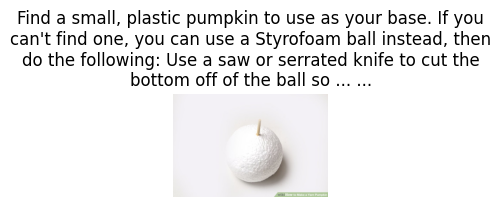

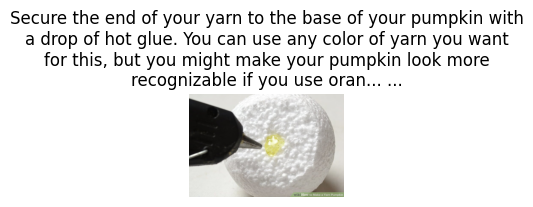

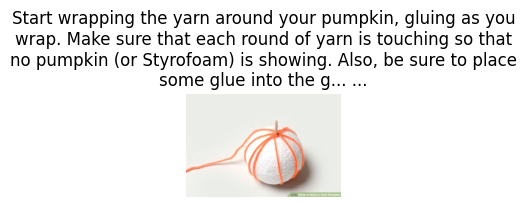

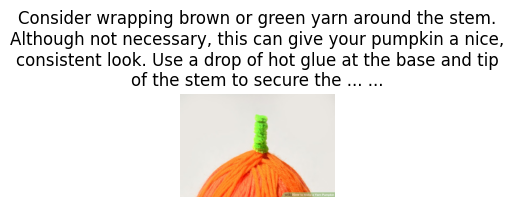

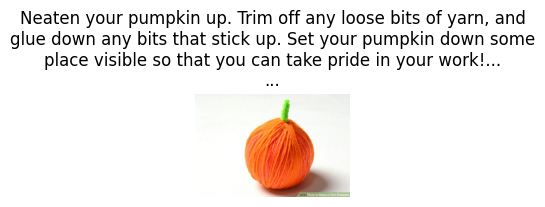

In [22]:
rand_idx = np.random.randint(len(data_wikihow))

print(data_wikihow[rand_idx].multiref_gt)
print(rand_idx)

show_one_sampled_data_wikihow(
    data_wikihow[rand_idx], 
    scrambled=False,
    title_max_len=200,
    show_url=True,
    img_size=2,
    # unimodal="text",
)

In [116]:
# Interesting indices: 

# acl22_human_multiref_multimodal
# 86, 

### Preconds and Sequencing

In [23]:
preconds_urls_and_section_ids = []
overlap_urls_and_section_ids = []
preconds_doc_ids_to_wikihow_data = {}

for key in golden_data:
    d = golden_data[key]
    first_sent = d["step_texts"][0]["text"].split(".")[0]
    preconds_urls_and_section_ids.append((first_sent, d["doc_id"]))

for d in data_wikihow:
    # wikihow_urls_and_section_ids.append(d.guid)
    url = d.guid.split("###")[0]
    first_sent = d.text_seq[0].split(".")[0]
    for _sent, doc_id in preconds_urls_and_section_ids:
        if first_sent == _sent and url == doc_id.split("###")[0]:
            overlap_urls_and_section_ids.append(doc_id)
            preconds_doc_ids_to_wikihow_data[doc_id] = d
            
# pprint.pprint(overlap_urls_and_section_ids)
# raise
    
# for doc_id in preconds_urls_and_section_ids:
#     if doc_id in wikihow_urls_and_section_ids:
#         overlap_urls_and_section_ids.append(doc_id)
        
print("Overlapping: {}".format(len(overlap_urls_and_section_ids)))

overlapped_multiref_cnt = 0
overlapped_multiref_doc_ids = []
# for d in data_wikihow:
#     if d.guid in preconds_urls_and_section_ids and len(d.multiref_gt) > 1:
#         overlapped_multiref_cnt += 1
#         overlapped_multiref_doc_ids.append(d.guid)
for doc_id, d in preconds_doc_ids_to_wikihow_data.items():
    if len(d.multiref_gt) > 1:
        overlapped_multiref_cnt += 1
        overlapped_multiref_doc_ids.append(d.guid)

print("Overlapped multi-ref count: {}".format(overlapped_multiref_cnt))
pprint.pprint(overlapped_multiref_doc_ids)

Overlapping: 69
Overlapped multi-ref count: 5
['https://www.wikihow.com/Peel-a-Grape###0',
 'https://www.wikihow.com/Cook-Fingerling-Potatoes###0',
 'https://www.wikihow.com/Charge-a-Kindle-Paperwhite###0',
 'https://www.wikihow.com/Dry-Herbs###0',
 'https://www.wikihow.com/Recycle-Cans-to-Make-Garden-Decor###0']


251
URL: https://www.wikihow.com/Dry-Herbs  Section: 1

Step: 1
Pick the herbs for cooking with.
-------------------------------- Golden Traces --------------------------------

Step: 2
Lay a clean tea towel out flat on a suitable surface. A kitchen bench or the sink are ideal spots. Alternatively, use a dish drying rack. Lay the tea towel on the rack; this will allow for greater air circulation. {`` smallUrl'':'' https: \/\/www.wikihow.com\/images\/thumb\/9\/93\/Dry- Herbs- Step-6Bullet1.jpg\/v4- 460px- Dry- Herbs- Step-6Bullet1.jpg'','' bigUrl'':'' \/images\/thumb\/9\/93\/Dry- Herbs- Step-6Bullet1.jpg\/aid2862681- v4- 728px- Dry- Herbs- Step-6Bullet1.jpg'','' smallWidth'': 460,'' smallHeight'': 300,'' bigWidth'': 728,'' bigHeight'': 474,'' licensing'':''< div class=\'' mw- parser- output\''
-------------------------------- Golden Traces --------------------------------
pre-condition: (Step 1) Pick the herbs for cooking with => Lay a clean tea towel out flat on a suitable surface
pre-

[0, 1, 2, 3, 4]

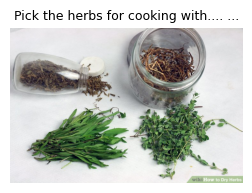

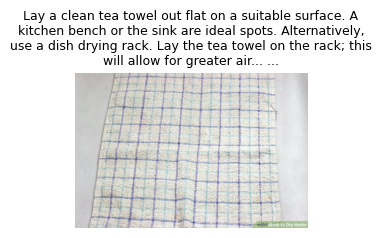

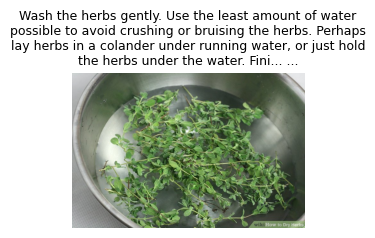

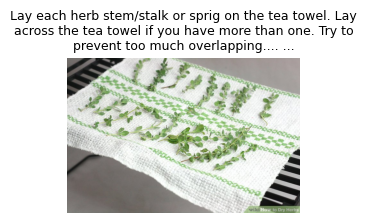

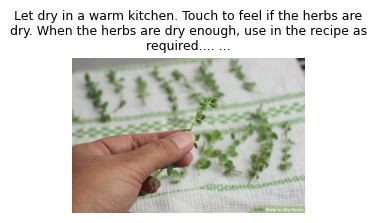

In [24]:
# wikihow_sequencing_indices = sorted(
#     [idx for idx in range(len(data_wikihow))
#      if data_wikihow[idx].guid in overlapped_multiref_doc_ids]
# )

wikihow_sequencing_indices_and_doc_ids = []
for doc_id, d in preconds_doc_ids_to_wikihow_data.items():
    for idx in range(len(data_wikihow)):
        if data_wikihow[idx] == d and len(d.multiref_gt) > 1:
            wikihow_sequencing_indices_and_doc_ids.append((idx, doc_id))
wikihow_sequencing_indices_and_doc_ids = sorted(wikihow_sequencing_indices_and_doc_ids)
# raise

# doc_id = data_wikihow[overlapped_rand_idx].guid
overlapped_rand_idx_and_doc_id = np.random.choice(np.arange(len(wikihow_sequencing_indices_and_doc_ids)))
overlapped_rand_idx_and_doc_id = wikihow_sequencing_indices_and_doc_ids[overlapped_rand_idx_and_doc_id]
overlapped_rand_idx, doc_id = overlapped_rand_idx_and_doc_id

print(overlapped_rand_idx)

# Inspect.
compare_golden_and_heuristics(
    golden_data=golden_data,
    # golden_heus=golden_heus,
    # temp_data=golden_temp,
    # model_name_and_preds=model_name_and_preds,
    doc_id=doc_id,
    show_version="v1",
    highlight_spans=True,
)

print(data_wikihow[overlapped_rand_idx].multiref_gt)
print(data_wikihow[overlapped_rand_idx].guid)

# Inspect.
show_one_sampled_data_wikihow(
    data_wikihow[overlapped_rand_idx], 
    scrambled=False,
    title_max_len=200,
    # show_url=True,
    img_size=3,
    font_size=9,
    # unimodal="text",
)

In [25]:
# Overlapped interesting indices:
# ...

# EPIC-KITCHENS-100

In [2]:
t = datetime.strptime("00:00:05.07","%H:%M:%S.%f")
delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond)
print(delta.total_seconds())

5.07


In [3]:
epic_kitchens_root = "/local1/telinwu/research/resources/EPIC-KITCHENS-100/"
epic_kitchens_train_file = "EPIC_100_train.csv"
epic_kitchens_train_file = os.path.join(epic_kitchens_root, "epic-kitchens-100-annotations", epic_kitchens_train_file)
epic_kitchens_csv = csv.DictReader(open(epic_kitchens_train_file))

In [4]:
epic_kitchens_data = {}

for row in epic_kitchens_csv:
    video_id = row["video_id"]
    if video_id not in epic_kitchens_data:
        epic_kitchens_data[video_id] = []
    
    curr_timestamp = {}
    for key in row:
        if key in ["video_id", "participant_id", "narration_id", "narration_timestamp"]:
            continue
        if key in ["all_nouns", "all_noun_classes"]:
            row[key] = literal_eval(row[key])
        curr_timestamp[key] = row[key]
    epic_kitchens_data[video_id].append(curr_timestamp)
    
for video_id in epic_kitchens_data:
    epic_kitchens_data[video_id] = sorted(
        epic_kitchens_data[video_id],
        key=lambda x: int(x["start_frame"])
    )

In [5]:
epic_kitchens_video_ids = sorted(list(epic_kitchens_data.keys()))

pprint.pprint(epic_kitchens_video_ids[:3])

['P01_01', 'P01_02', 'P01_03']


In [7]:
# pprint.pprint(epic_kitchens_data["P01_02"])
video_id = "P01_02"
video_id = "P03_04"
# video_id = np.random.choice(epic_kitchens_video_ids)
print("Video ID: {}".format(video_id))
video = epic_kitchens_data[video_id]

event_id = 1
main_verbs = []
main_nouns = []
for event in video:
    all_verbs, all_nouns = event["verb"], event["all_nouns"]
    main_verbs += [all_verbs]
    main_nouns += all_nouns
main_verbs = sorted(list(set(main_verbs)))
main_nouns = sorted(list(set(main_nouns)))
print("Main Verbs: {}".format(main_verbs))
print("Main Nouns: {}".format(main_nouns))
prev_stop_time = None
for event in video:
    start_timestamp, stop_timestamp = event["start_timestamp"], event["stop_timestamp"]
    narration = event["narration"]
    t = datetime.strptime(start_timestamp, "%H:%M:%S.%f")
    delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond)
    curr_start_time = delta.total_seconds()
    t = datetime.strptime(stop_timestamp, "%H:%M:%S.%f")
    delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond)
    curr_stop_time = delta.total_seconds()
    if prev_stop_time is not None and curr_start_time < prev_stop_time:
        print("({:04d}) [{}-{}] {} (↑)".format(event_id, start_timestamp, stop_timestamp, narration))
    else:
        print("({:04d}) [{}-{}] {} ".format(event_id, start_timestamp, stop_timestamp, narration))
    event_id += 1
    prev_stop_time = curr_stop_time

Video ID: P03_04
Main Verbs: ['check', 'chop', 'clean', 'close', 'crumble', 'cut', 'cut-in', 'dice', 'dry', 'fill', 'fold', 'get', 'grab', 'move', 'open', 'peel', 'pick-up', 'pour', 'pour-into', 'pull-out', 'put', 'put-down', 'put-in', 'put-into', 'put-on', 'serve', 'shake', 'sharpen', 'slice', 'spoon', 'stir', 'take', 'take-off', 'take-out', 'throw-in', 'transfer', 'turn-down', 'turn-off', 'turn-on', 'turn-up', 'wash']
Main Nouns: ['almond', 'bag', 'bag:food', 'bin', 'board', 'board:chopping', 'board:cutting', 'bottle', 'bowl', 'box', 'box:lunch', 'can', 'chicken', 'corn:sweet', 'crisp', 'cube:stock', 'cup:measuring', 'cupboard', 'cutlery', 'drawer', 'drink', 'food', 'freezer', 'fridge', 'glass', 'granule', 'hand', 'heat', 'hob', 'kettle', 'knife', 'lid', 'milk:coconut', 'oil:olive', 'onion', 'opener:can', 'pan', 'paste:garlic', 'peel', 'pepper', 'plastic', 'plate', 'salmon', 'saucepan', 'sharpener:knife', 'side', 'soap', 'spatula', 'spice', 'spoon', 'squash', 'stock', 'tap', 'top', '

In [310]:
# Interesting video ids:
# ...

# Ego4D

In [335]:
# Use annotations to filter out the videos list we want.
annots_root = "/local1/hu528/ego4d_data/v1/annotations/"
curr_videos_root = "/local1/jrbronkar/ego4d_videos/v1/full_scale"

all_narrations_file = os.path.join(annots_root, "narration.json")
all_narrations = json.load(open(all_narrations_file))

In [366]:
def show_one_ego4d_narration(
    all_narrations,
    video_uid=None,
    narration_pass="narration_pass_1",
):
    if video_uid is None:
        video_uid = np.random.choice(list(all_narrations.keys()))
    summaries = all_narrations[video_uid][narration_pass]["summaries"]
    curr_narrations = all_narrations[video_uid][narration_pass]["narrations"]
    print("Video: {}".format(video_uid))
    print("Summary: {}".format(summaries))
    timed_narrations = []
    
    for i in range(len(curr_narrations)):
        timestamp_sec = curr_narrations[i]["timestamp_sec"]
        timestamp_frame = curr_narrations[i]["timestamp_frame"]
        narration_text = curr_narrations[i]["narration_text"]
        timed_narrations.append((timestamp_sec, timestamp_frame, narration_text))
    
    print("-"*50)
    for a, b, c in timed_narrations:
        print("[{}]({}) {}".format(str(timedelta(seconds=a))[:10], b, c))
    print("-"*50)
    
    return timed_narrations


timed_narrations = show_one_ego4d_narration(
    all_narrations,
    video_uid=None,
    narration_pass="narration_pass_1",
)

Video: c6f54284-21ce-4db0-88b2-f528304c09f5
Summary: [{'start_sec': 1350.0320312, 'end_sec': 1501.032031533333, 'summary_text': 'C sat at a table. C hit pins into a leaflet with a hammer. #summary', 'annotation_uid': '1893f841-0deb-452b-8b50-dc43147cb6d9'}]
--------------------------------------------------
[0:00:01.19](35) #C C operates his phone
[0:00:04.05](121) #C C shifts a paper on the table
[0:00:07.72](231) #C C opens a nylon
[0:00:12.20](365) #C C takes a small nylon from the big nylon
[0:00:13.53](405) #C C drops the small nylon on the table
[0:00:14.77](442) #C C takes a card from inside the nylon
[0:00:18.36](550) #C C drops the card on the table
[0:00:19.76](592) #C C takes a wood from inside the nylon
[0:00:25.24](756) #C C drops the wood on the table
[0:00:27.09](812) #C C drops other wood in the nylon on the table
[0:00:31.00](929) #C C holds the nylon up
[0:00:36.40](1091) #C C drops the nylon on the table
[0:00:37.67](1129) #C C takes a paper from underneath the nylon

# END